In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Simulating pore with varying tether length and sequences

In [2]:
10.57*0.8518

9.003526

In [1]:
'''
Initialise functions for plotting and processing data
'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video


#centre of barrel
xc = (60.57 + 39.43)/2
yc = 50
zc = 69.96
lengthToNm = 0.8518 
timeTons   = 3.03e-3
barHeight = 61.05

connShift = [0, 1134]


def getPoreNt(teth_len, numConn = 0):
    scaf_start = 0 + connShift[numConn]
    scaf_end   = 593-40 + teth_len*2 + connShift[numConn]
    return np.arange(teth_len + scaf_start, scaf_end - teth_len)
    
    
def getTopNt(teth_len, numConn = 0):
    print(connShift[numConn])
    return teth_len + connShift[numConn]
    
def getMidNt(teth_len, numConn = 0):
    return teth_len + 44 + connShift[numConn]

def getBotNt(teth_len, numConn = 0):
    return teth_len + 89 + connShift[numConn]
    
    
def RMS(x, y, z):
    #takes a vector (e.g. velocity) broken into components x,y,z and returns the RMS value
    return np.sqrt(x**2 + y**2 + z**2)


def getPosition(data, nt, pos, vel, rot):
    #takes data and returns position in nm relative to centre of barrel
    xpos = data[:,0 + 3*nt*(pos + vel + rot)] 
    ypos = data[:,1 + 3*nt*(pos + vel + rot)] 
    zpos = data[:,2 + 3*nt*(pos + vel + rot)] 
    xpos = (xpos - xc)*lengthToNm
    ypos = (ypos - yc)*lengthToNm
    zpos = (zpos - zc)*lengthToNm
    return [xpos, ypos, zpos]

def getVelocity(data, nt, pos, vel, rot):
    #takes data and returns velocity in nm/ns relative to centre of barrel
    xvel = data[:,3 + 3*nt*(pos + vel + rot)] 
    yvel = data[:,4 + 3*nt*(pos + vel + rot)] 
    zvel = data[:,5 + 3*nt*(pos + vel + rot)] 
    xvel = xvel*lengthToNm/timeTons
    yvel = yvel*lengthToNm/timeTons
    zvel = zvel*lengthToNm/timeTons
    return [xvel, yvel, zvel]


def getAngularV(data, nt, pos, vel, rot):
    #takes data and returns angular velocity in 1/ns relative to centre of barrel
    xrot = data[:,6 + 3*nt*(pos + vel + rot)] 
    yrot = data[:,7 + 3*nt*(pos + vel + rot)] 
    zrot = data[:,8 + 3*nt*(pos + vel + rot)] 
    xrot = xrot/timeTons/np.pi*180
    yrot = yrot/timeTons/np.pi*180
    zrot = zrot/timeTons/np.pi*180
    return [xrot, yrot, zrot]


def takeMean(Vec):
    #given a list takes the mean along each coordinate
    for i in range(len(Vec)):
        Vec[i] = np.mean(Vec[i],1)
    return Vec


def takeMin(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).min(1)
    return Vec   
    
def takeMax(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).max(1)
    return Vec

def cartToCyl(x,y,z):
    #converts Cartesian coords to cylindrical coordinates in degrees
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(posV[1], posV[0])/np.pi*180
    return [r, theta, z]


def plotPositionHist(posV, pType = 'z', title = None, vline = None, saveName = None):
    '''
    plots the histogram of a spatial or angular coordinate
    posV is the position vector
    pType = 'x', 'y', 'z', 't' (theta), 'r' (radial)
    '''   
    plt.figure()
    plt.xlabel('Position (nm)')
    if pType == 'x':
        pos = posV[0]
        plt.title('Histogram of location of pore - x-position')
    elif pType == 'y':
        pos = posV[1]
        plt.title('Histogram of location of pore - y-position')        
    elif pType == 'z':
        pos = posV[2]
        plt.title('Histogram of location of pore - z-position')
    elif pType == 'r':
        pos = np.sqrt(posV[0]**2 + posV[1]**2)
        plt.title('Histogram of location of pore - r-position')
        plt.xlabel('Radial distance from centre of pore (nm)')
    elif pType == 't':
        pos = np.arctan2(posV[1], posV[0])/np.pi*180     
        plt.title('Histogram of location of pore - angular distance of pore in barrel')
        plt.xlabel('Angular distance of pore in barrel (degrees)')

    if title is not None:
        plt.title(title)
        
    plt.hist(pos, density = True, bins = int(np.sqrt(len(pos))))
    
    xmin, xmax, ymin, ymax = plt.axis()    
    if vline is not None:
        plt.vlines(vline, 0, ymax, 'r')
    plt.ylabel('Probability density')
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight')        
    plt.show()

    
    
def plotRMSHist(Vec, pType = 'vel', saveName = None):
    '''
    plots the histogram of a spatial or angular coordinate
    Vec is a vector: either position, velocity or angular velocity
    pType = 'pos', 'vel', 'rot'
    '''       
    RMSVec = RMS(Vec[0], Vec[1], Vec[2])
    plt.figure()
    plt.hist(RMSVec, density = True)
    plt.ylabel('Probability density')

    if pType == 'pos':
        plt.xlabel('Average root mean squared position (nm)')
        plt.title('Histogram of average root mean squared position')
    elif pType == 'vel':
        plt.xlabel('Average root mean squared velocity (nm/ns)')
        plt.title('Histogram of average root mean squared velocity')
    elif pType == 'rot':
        plt.xlabel('Average root mean squared angular velocity (degrees/ns)')
        plt.title('Histogram of average root mean squared angular velocity')
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight')    
    plt.show()



def plotMeanStdPair(xval, Means, Stds, ylabel1 = '', ylabel2 = '', xlabel = 'Tether length (bp)', title = '', saveName = None):
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color='b')
    ax1.plot(xval, Means, 'bo')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel(ylabel2, color='r')  
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.plot(xval, Stds, 'rx')
    plt.title(title)
    fig.tight_layout() 
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight') 
    plt.show()
        
    
#plot mean-standard deviation pair with error bars
def plotMeanStdEB(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[1]):
            plt.errorbar(xval, Means[:,i], Stds[:,i], fmt=shapes[i] + ':', label = legend[i])
    
    if hline is not None:
        plt.hlines(hline, xval[0], xval[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()    

    
#plot mean-standard deviation pair with error bars inverse
def plotMeanStdEBInverse(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[0]):
            plt.errorbar(legend, Means[i,:], Stds[i,:], fmt=shapes[i] + ':', label = xval[i])
    
    if hline is not None:
        plt.hlines(hline, legend[0], legend[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()        

In [4]:
'''
Loop over data
'''

N = 4
M = 20

poreEnd = 43

ave_z   = np.zeros([N,M])
ave_r   = np.zeros([N,M])
ave_th  = np.zeros([N,M])
std_z   = np.zeros([N,M])
std_r   = np.zeros([N,M])
std_th  = np.zeros([N,M])

ave_top_z   = np.zeros([N,M])
ave_top_r   = np.zeros([N,M])
ave_top_th  = np.zeros([N,M])
std_top_z   = np.zeros([N,M])
std_top_r   = np.zeros([N,M])
std_top_th  = np.zeros([N,M])

ave_mid_z   = np.zeros([N,M])
ave_mid_r   = np.zeros([N,M])
ave_mid_th  = np.zeros([N,M])
std_mid_z   = np.zeros([N,M])
std_mid_r   = np.zeros([N,M])
std_mid_th  = np.zeros([N,M])

ave_bot_z   = np.zeros([N,M])
ave_bot_r   = np.zeros([N,M])
ave_bot_th  = np.zeros([N,M])
std_bot_z   = np.zeros([N,M])
std_bot_r   = np.zeros([N,M])
std_bot_th  = np.zeros([N,M])

ave_min_z   = np.zeros([N,M])
ave_min_r   = np.zeros([N,M])
ave_min_th  = np.zeros([N,M])
std_min_z   = np.zeros([N,M])
std_min_r   = np.zeros([N,M])
std_min_th  = np.zeros([N,M])

ave_bonds   = np.zeros([N,M])
std_bonds   = np.zeros([N,M])
max_bonds   = np.zeros([N,M])
min_bonds   = np.zeros([N,M])
end_bonds   = np.zeros([N,M])


FracOut = np.zeros([N,M])

minBonds = 0 #[495, 495 + 60, 495 + 11*15, 495 + 84*2, 495 + 84*2] #84*2 is the cinch length

teth_len = 120
conns = [1,1,1,1]

for c in range(N):
    for m in range(M):
        print('Now processing : MD' + str(c) + ', seed: ' + str(m))
        #data = np.genfromtxt('MD' + str(c) + '/outpos' + str(m) + '.dat')
        data = np.genfromtxt('MD' + str(c) + '/jointpos.dat')
        
        #nucleotide to track
        nt = getPoreNt(teth_len, numConn = conns[c])

        #Get mean positions
        posV = takeMean(getPosition(data, nt, 1, 0, 0))

        #if pore is in opposite orientation
        zsign = 1
        '''
        if np.mean(posV[2]) > 0:
            zsign = -1
        else:
            zsign = 1
        '''

        ave_z[c,m]   = np.mean(posV[2])*zsign
        ave_r[c,m]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_th[c,m]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_z[c,m]   = np.std(posV[2])
        std_r[c,m]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_th[c,m]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))

        #Get top positions
        posV = getPosition(data, getTopNt(teth_len, numConn = conns[c]), 1, 0, 0)
        ave_top_z[c,m]   = np.mean(posV[2])*zsign
        ave_top_r[c,m]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_top_th[c,m]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_top_z[c,m]   = np.std(posV[2])
        std_top_r[c,m]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_top_th[c,m]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))

        #Get middle positions
        posV = getPosition(data, getMidNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_mid_z[c,m]   = np.mean(posV[2])*zsign
        ave_mid_r[c,m]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_mid_th[c,m]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_mid_z[c,m]   = np.std(posV[2])
        std_mid_r[c,m]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_mid_th[c,m]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))

        #Get bottom positions
        posV = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_bot_z[c,m]   = np.mean(posV[2])*zsign
        ave_bot_r[c,m]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_bot_th[c,m]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_bot_z[c,m]   = np.std(posV[2])
        std_bot_r[c,m]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_bot_th[c,m]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))


        #Get minimum positions
        posV = takeMin(getPosition(data, nt, 1, 0, 0))            
        ave_min_z[c,m]   = np.mean(posV[2])*zsign
        ave_min_r[c,m]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_min_th[c,m]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_min_z[c,m]   = np.std(posV[2])
        std_min_r[c,m]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_min_th[c,m]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))

        #fraction of time outside the pore
        FracOut[c] = sum(abs(posV[2][i]) > poreEnd  for i in range(len(posV[2])))/len(posV[2])

        #number of bonds
        bonds = np.genfromtxt('MD' + str(c) + '/numbonds.txt')  
        #bonds = np.genfromtxt('MD' + str(c) + '/numbonds' + str(m) + '.txt')    
        
        bonds = bonds - minBonds
        bonds = bonds.clip(min=0)
        ave_bonds[c,m]   = np.mean(bonds)
        std_bonds[c,m]   = np.std(bonds)
        max_bonds[c,m]   = np.max(bonds)
        min_bonds[c,m]   = np.min(bonds)        
        end_bonds[c,m]   = bonds[-1]
        
        
print('Finished processing')

Now processing : MD0, seed: 0
1134
Now processing : MD1, seed: 0
1134
Now processing : MD2, seed: 0
1134
Now processing : MD3, seed: 0
1134
Finished processing


Text(0, 0.5, 'Number of bonds')

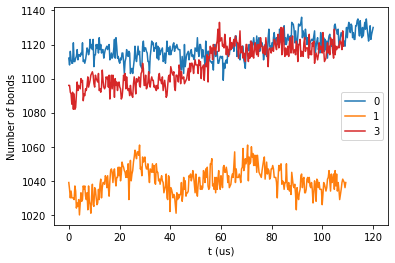

In [2]:
bonds = []
md = [0,1,3]
col = ['tab:blue', 'tab:orange', 'tab:red']
plt.figure()
for i in range(3):
    bonds.append(np.genfromtxt('MD' + str(md[i]) + '/numbonds.txt'))
    plt.plot(np.arange(len(bonds[i]))*0.3, bonds[i], color = col[i])
plt.legend(md)
plt.xlabel('t (us)')
plt.ylabel('Number of bonds')

In [10]:
print(max(bonds[0]), max(bonds[1]), max(bonds[2]))

1136.0 1061.0 1133.0


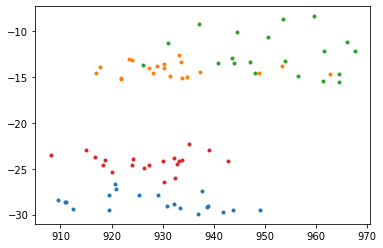

In [66]:
plt.plot(ave_bonds.transpose(), ave_top_z.transpose(), '.')
plt.show()

In [44]:
bondTS = []
av_bTS = []
mx_bTS = []
mn_bTS = []
sd_bTS = []

endTime = 1e15
for i in range(N):
    bonds = []
    for j in range(M):
        bonds.append(np.genfromtxt('MD' + str(i) + '/numbonds' + str(j) + '.txt'))
        if len(bonds[j]) < endTime:
            endTime = len(bonds[j])
    bondTS.append(bonds)

for i in range(N):
    bonds = []
    mxbnd = []
    mnbnd = []
    sdbnd = []
    
    for t in range(endTime):
        tmp = []
        for j in range(M):
            tmp.append(bondTS[i][j][t])
        bonds.append(np.sum(tmp)/M)
        mxbnd.append(np.max(tmp))
        mnbnd.append(np.min(tmp))
        sdbnd.append(np.std(tmp))        
    av_bTS.append(bonds)
    mx_bTS.append(mxbnd)
    mn_bTS.append(mnbnd)
    sd_bTS.append(sdbnd)
    

Text(0, 0.5, 'Number of bonds')

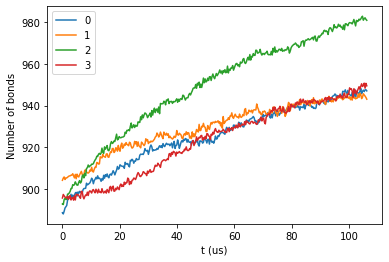

In [43]:
bonds = []
plt.figure()
for i in range(4):
    plt.plot(np.arange(endTime)*0.3, av_bTS[i])
plt.legend(range(4))
plt.xlabel('t (us)')
plt.ylabel('Number of bonds')

Text(0, 0.5, 'Ensemble average number of bonds')

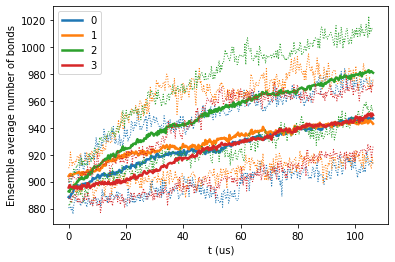

In [62]:
initTime = 0
time = np.arange(endTime)*0.3
time += initTime
bonds = []
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
plt.figure()
for i in range(4):
    plt.plot(time, av_bTS[i], color = col[i], lw = 2.5, label = str(i))
    plt.plot(time, mx_bTS[i], ':', color = col[i], lw = 1, label = None)
    plt.plot(time, mn_bTS[i], ':', color = col[i], lw = 1, label = None)
    
    #plt.fill_between(time, mn_bTS[i], mx_bTS[i])
plt.legend()
plt.xlabel('t (us)')
plt.ylabel('Ensemble average number of bonds')



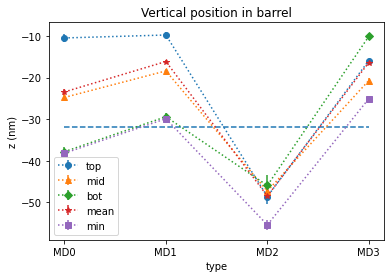

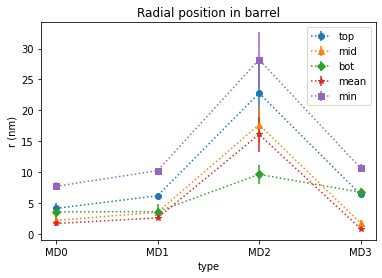

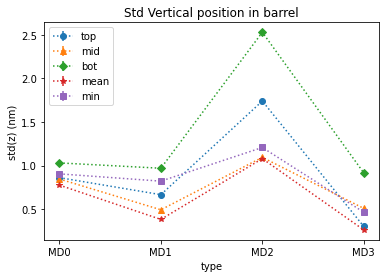

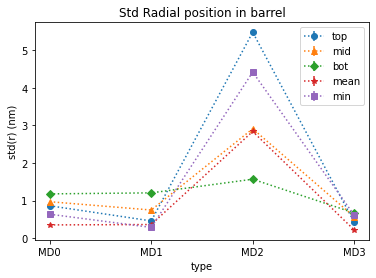

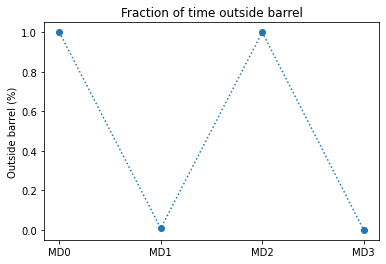

In [10]:
'''
Comparison between the different pores
'''

teth_lens = [teth_len]
seqNames = ['MD0', 'MD1', 'MD2', 'MD3']
types = ['top', 'mid', 'bot', 'mean', 'min']
ave_zs    = np.array([ave_top_z[:,0], ave_mid_z[:,0], ave_bot_z[:,0], ave_z[:,0], ave_min_z[:,0]])
std_zs    = np.array([std_top_z[:,0], std_mid_z[:,0], std_bot_z[:,0], std_z[:,0], std_min_z[:,0]])
ave_rs    = np.array([ave_top_r[:,0], ave_mid_r[:,0], ave_bot_r[:,0], ave_r[:,0], ave_min_r[:,0]])
std_rs    = np.array([std_top_r[:,0], std_mid_r[:,0], std_bot_r[:,0], std_r[:,0], std_min_r[:,0]])

plotMeanStdEBInverse(types, ave_zs, std_zs, ylabel = 'z (nm)', title = 'Vertical position in barrel', legend = seqNames, xlabel = 'type', hline = -32)
plotMeanStdEBInverse(types, ave_rs, std_rs, ylabel = 'r (nm)', title = 'Radial position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_zs, std_zs*0, ylabel = 'std(z) (nm)', title = 'Std Vertical position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_rs, std_rs*0, ylabel = 'std(r) (nm)', title = 'Std Radial position in barrel', legend = seqNames, xlabel = 'type')

plt.figure()
plt.plot(seqNames, FracOut, 'o:')
plt.ylabel('Outside barrel (%)')
plt.title('Fraction of time outside barrel')
plt.show()
#plotMeanStdEBInverse(teth_lens, 100*FracOut, 0*FracOut, ylabel = 'Outside barrel (%)', title = 'Fraction of time outside barrel', legend = seqNames, xlabel = 'type')
#plotMeanStdEBInverse(teth_lens, ave_bonds, std_bonds, ylabel = 'Number of tether bonds', title = 'Bonding on tether', legend = seqNames, xlabel = 'type')

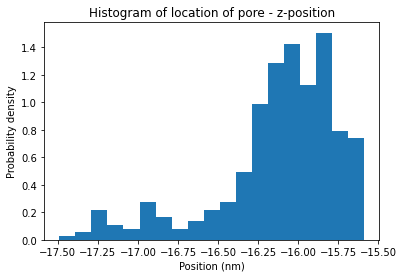

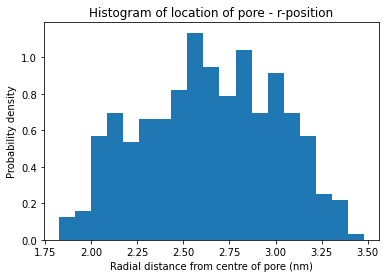

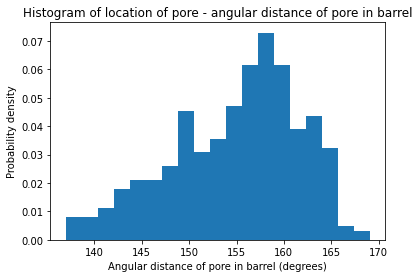

1134


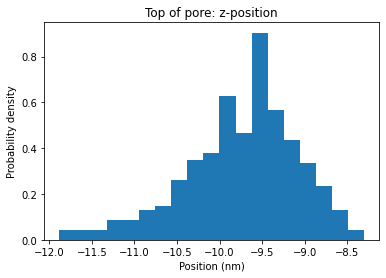

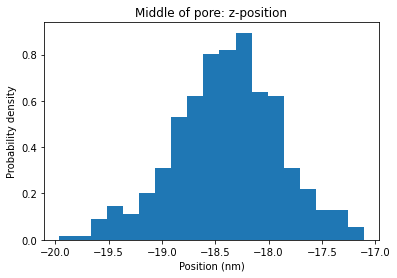

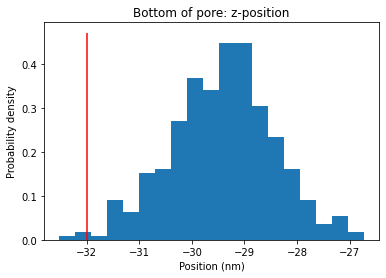

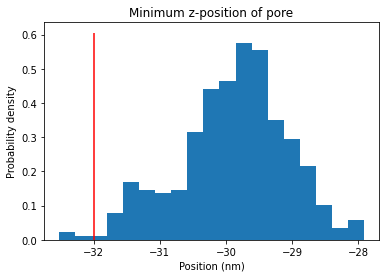

In [16]:
'''
Import data for tether length 45
'''

folder = 'MD1/'
data = np.genfromtxt(folder + '/jointpos.dat')

teth_len = 120

#nucleotide to track
nt = getPoreNt(teth_len,1)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 0, 0))

folder = folder + '/pics/'

#Plot histograms
plotPositionHist(posV, 'z', saveName = folder + 'zhist')
plotPositionHist(posV, 'r', saveName = folder + 'zhist')
plotPositionHist(posV, 't', saveName = folder + 'thethist')

#bottom, middle and top of pore
plotPositionHist(getPosition(data, getTopNt(teth_len,1), 1, 0, 0), 'z', title = 'Top of pore: z-position', saveName = folder + 'top_zhist')
plotPositionHist(getPosition(data, getMidNt(teth_len,1), 1, 0, 0), 'z', title = 'Middle of pore: z-position', saveName = folder + 'mid_zhist')
plotPositionHist(getPosition(data, getBotNt(teth_len,1), 1, 0, 0), 'z', title = 'Bottom of pore: z-position', vline = -32, saveName = folder + 'bot_zhist')
plotPositionHist(takeMin(getPosition(data, nt, 1, 0, 0)), 'z', title = 'Minimum z-position of pore', vline = -32, saveName = folder + 'min_zhist')